A partir de http://flothesof.github.io/2D-potential-flow-finite-differences.html

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Lx = 4

def make_grid(Lx=4, Ly=5, nx=50, ny=50):
    """Make a rectangular grid, with coordinates centered on (0, 0)."""
    x = np.linspace(0, Lx, num=nx) - Lx/2
    y = np.linspace(0, Ly, num=ny) - Ly/2
    X, Y = np.meshgrid(x, y)
    return X, Y

grid = make_grid(nx=100, ny=100)
x = np.linspace(0, Lx/2, num=100) - Lx/4

<ipython-input-2-4c9fdf8be8e0>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(grid[0], grid[1], R)


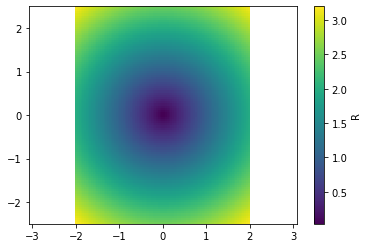

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

R = np.sqrt(grid[0]**2 + grid[1]**2)

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], R)
plt.colorbar(m, ax=ax, label='R')
ax.axis('equal');

<ipython-input-3-de07d48dc061>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(grid[0], grid[1], R)


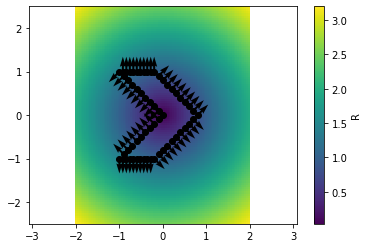

In [3]:
"""
##### define a parametric circle
t = np.linspace(0, 2 * np.pi, num=35, endpoint=False)
x, y = np.cos(t), np.sin(t)
nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], R)
plt.colorbar(m, ax=ax, label='R')
ax.plot(x, y, 'ok')
ax.quiver(x, y, nx, ny) #tracé de vecteurs (nx,ny) de positions (x,y)
ax.axis('equal');"""



# define a parametric 2D cone
t = np.linspace(0, np.max(x), num=10, endpoint=False)
xhg, yhg = -np.max(x)+t,np.max(x)-t 
xbg,ybg = -t,-t
xhd, yhd = -t+Lx/5,t 
xbd,ybd = -np.max(x)+t+Lx/5,-np.max(x)+t
xh,yh = ((np.max(x)-t)/np.max(x))*Lx/5-np.max(x),np.max(x)*np.ones(np.shape(t)[0])
xb,yb = (t/np.max(x))*Lx/5-np.max(x),-np.max(x)*np.ones(np.shape(t)[0])
x = np.concatenate((xbg,xb,xbd,xhd,xh,xhg))
y= np.concatenate((ybg,yb,ybd,yhd,yh,yhg))

nxbg,nybg = -1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),+1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxbd,nybd =1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),-1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxhg,nyhg =-1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),-1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxhd,nyhd =+1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),+1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxh,nyh= 0*np.ones((np.shape(xhg)[0])),1*np.ones((np.shape(xhg)[0]))
nxb,nyb = 0*np.ones((np.shape(xhg)[0])),-1*np.ones((np.shape(xhg)[0]))


nx, ny = np.concatenate((nxbg,nxb,nxbd,nxhd,nxh,nxhg)), np.concatenate((nybg,nyb,nybd,nyhd,nyh,nyhg))

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], R)
plt.colorbar(m, ax=ax, label='R')
ax.plot(x, y, 'ok')
ax.quiver(x, y, nx, ny) #tracé de vecteurs (nx,ny) de positions (x,y)
ax.axis('equal');

<ipython-input-4-6ca26b05a310>:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))


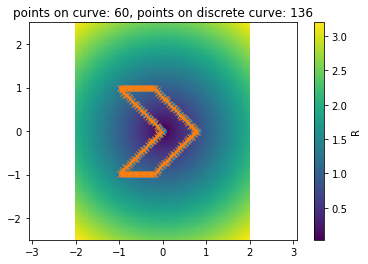

In [4]:
from skimage import draw

def transform_grid_coords_to_xy(grid_coords, grid):
    """Transform rc coords to xy coords from the grid."""
    X, Y = grid
    x_disc = np.array([X[rc[0], rc[1]] for rc in grid_coords])
    y_disc = np.array([Y[rc[0], rc[1]] for rc in grid_coords])
    return x_disc, y_disc

def rasterize_points_to_grid_coords(x, y, grid):
    """Rasterizes a discrete set of (x, y) points to a grid. Returns (r, c) coordinates."""
    X, Y = grid
    X_flat, Y_flat = X.flatten(), Y.flatten()

    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)
    R_flat, C_flat = R.flatten(), C.flatten()

    coords = np.c_[X_flat, Y_flat]
    coords_rc = np.c_[R_flat, C_flat]
    
    # first part: discretize each point from x and y while avoiding duplicates
    rcs = []
    discrete_coords = []
    already_seen_points = set()
    for xx, yy in zip(x, y):
        dist = ((coords - np.array([xx, yy]).reshape(1, -1))**2).sum(axis=1)
        argmin = dist.argmin()
        if argmin not in already_seen_points:            
            rc = coords_rc[argmin]
            rcs.append(rc)
            discrete_coords.append(coords[argmin])
            already_seen_points.add(argmin)

    discrete_coords = np.array(discrete_coords)
    x_disc, y_disc = transform_grid_coords_to_xy(rcs, grid)
    
    # sanity check
    assert np.allclose(np.c_[x_disc, y_disc], discrete_coords)

    # second part: use the Bresenham algorithm to discretize each segment
    N = len(rcs)
    grid_coords = []
    for start, stop in zip(range(N), range(1, N+1)):
        if stop >= N:
            stop = stop % N
        r0, c0 = rcs[start]
        r1, c1 = rcs[stop]
        rr, cc = draw.line(r0, c0, r1, c1)
        grid_coords.extend([r,c] for r, c in zip(rr[:-1], cc[:-1]))
        
    return np.array(grid_coords)

grid_coords = rasterize_points_to_grid_coords(x, y, grid)
x_disc, y_disc = transform_grid_coords_to_xy(grid_coords, grid)

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
plt.colorbar(m, ax=ax, label='R')
ax.plot(x, y, 'o')
ax.plot(x_disc, y_disc, '-x')
ax.set_title(f'points on curve: {x.size}, points on discrete curve: {x_disc.size}')
ax.axis('equal');

In [5]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
plt.colorbar(m, ax=ax, label='R')
l1, = ax.plot([], [], 'o')
l2, = ax.plot([], [], '-x')
ax.axis('equal')
    
def update(n):
    t = np.linspace(0, 2 * np.pi, num=n, endpoint=False)
    x, y = np.cos(t), np.sin(t)
    rcs = rasterize_points_to_grid_coords(x, y, grid)
    x_disc, y_disc = transform_grid_coords_to_xy(rcs, grid)
    l1.set_data(x, y)
    l2.set_data(x_disc, y_disc)
    ax.set_title(f'points on curve: {x.size}, points on discrete curve: {x_disc.size}')


anim = FuncAnimation(fig, update, frames=range(2, 50, 3))
#anim.save('anim2.mp4')
plt.close()
HTML(anim.to_jshtml())

<ipython-input-5-0d183df5552a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))


In [6]:
def rasterize_vectors_to_grid(x, y, nx, ny, grid):
    """Rasterizes a discrete set of (x, y) points and vectors (nx, ny) to a grid. 
    Returns (nx_disc, ny_disc) vector field."""

    X, Y = grid
    X_flat, Y_flat = X.flatten(), Y.flatten()

    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)
    R_flat, C_flat = R.flatten(), C.flatten()

    coords = np.c_[X_flat, Y_flat]
    coords_rc = np.c_[R_flat, C_flat]
    
    # first part: discretize each point from x and y while avoiding duplicates
    rcs = []
    discrete_coords = []
    discrete_vectors = []
    already_seen_points = set()
    for xx, yy, nxx, nyy in zip(x, y, nx, ny):
        dist = ((coords - np.array([xx, yy]).reshape(1, -1))**2).sum(axis=1)
        argmin = dist.argmin()
        if argmin not in already_seen_points:            
            rc = coords_rc[argmin]
            rcs.append(rc)
            discrete_coords.append(coords[argmin])
            discrete_vectors.append([nxx, nyy])
            already_seen_points.add(argmin)

    discrete_coords = np.array(discrete_coords)
    x_disc, y_disc = transform_grid_coords_to_xy(rcs, grid)
    
    # sanity check
    assert np.allclose(np.c_[x_disc, y_disc], discrete_coords)

    # second part: use the Bresenham algorithm to discretize each segment
    N = len(rcs)
    grid_coords = []
    rasterized_vector_field = []
    for start, stop in zip(range(N), range(1, N+1)):
        if stop >= N:
            stop = stop % N
        r0, c0 = rcs[start]
        r1, c1 = rcs[stop]
        nx0, ny0 = discrete_vectors[start]
        nx1, ny1 = discrete_vectors[stop]
        
        rr, cc = draw.line(r0, c0, r1, c1)
        N_interp = len(rr) 
        for i in range(N_interp - 1):
            alpha = i/N_interp
            grid_coords.append([rr[i], cc[i]])
            rasterized_vector_field.append([(1 - alpha) * nx0 + alpha * nx1,
                                            (1 - alpha) * ny0 + alpha * ny1])
    return np.array(rasterized_vector_field)

In [7]:
grid_coords = rasterize_points_to_grid_coords(x, y, grid)
x_disc, y_disc = transform_grid_coords_to_xy(grid_coords, grid)
rasterized_vector_field = rasterize_vectors_to_grid(x, y, nx, ny, grid)

assert rasterized_vector_field.shape[0] == x_disc.size

<ipython-input-8-bc7c7869c0da>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))


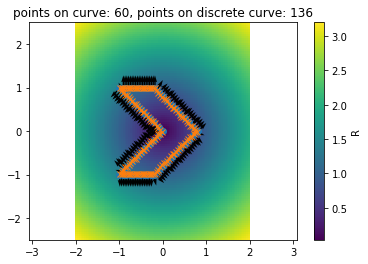

In [8]:
fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
plt.colorbar(m, ax=ax, label='R')
ax.plot(x, y, 'o')
ax.plot(x_disc, y_disc, '-x')
ax.quiver(x_disc, y_disc, rasterized_vector_field[:, 0], rasterized_vector_field[:, 1])
ax.set_title(f'points on curve: {x.size}, points on discrete curve: {x_disc.size}')
ax.axis('equal');

<ipython-input-9-51928c4e527b>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
<ipython-input-9-51928c4e527b>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
<ipython-input-9-51928c4e527b>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either spec

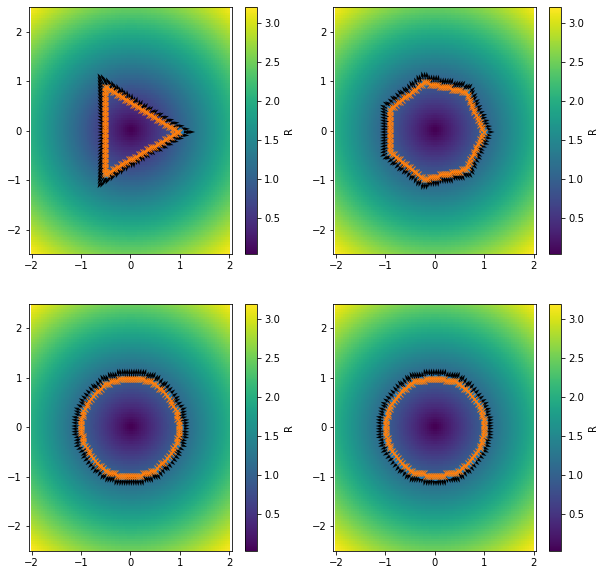

In [9]:
def make_data_and_plot(n, ax):
    t = np.linspace(0, 2 * np.pi, num=n, endpoint=False)
    x, y = np.cos(t), np.sin(t)
    nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)
    grid_coords = rasterize_points_to_grid_coords(x, y, grid)
    x_disc, y_disc = transform_grid_coords_to_xy(grid_coords, grid)
    rasterized_vector_field = rasterize_vectors_to_grid(x, y, nx, ny, grid)
    # plotting
    ax.plot(x, y, 'o')
    ax.plot(x_disc, y_disc, '-x')
    ax.quiver(x_disc, y_disc, rasterized_vector_field[:, 0], rasterized_vector_field[:, 1])

n_points = [3, 7, 18, 44]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

for ax, n in zip(axes.ravel(), n_points):
    m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
    make_data_and_plot(n, ax)
    plt.colorbar(m, ax=ax, label='R')
    ax.axis('equal')

In [10]:
from skimage.draw import polygon


def make_tags(grid, x, y):
    """Create a grid with tags defining each cell's type."""
    X, Y = grid
    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)

    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    EPS = 1e-5

    grid_coords = rasterize_points_to_grid_coords(x, y, grid)
    grid_coords_set = set((r,c) for (r,c) in grid_coords)
    mask = polygon(np.array(grid_coords)[:, 0], np.array(grid_coords)[:, 1], X.shape)
    mask_set = set((r, c) for r, c in zip(*mask))

    tags = np.zeros_like(R, dtype=np.int) * np.nan

    for r, c in zip(R.flatten(), C.flatten()):
        # left boundary
        if abs(X[r, c] - xmin) < EPS:
            tags[r, c] = 1
        # right boundary
        elif abs(X[r, c] - xmax) < EPS:
            tags[r, c] = 2
        # bottom boundary
        elif abs(Y[r, c] - ymin) < EPS:
            tags[r, c] = 3
        # top boundary
        elif abs(Y[r, c] - ymax) < EPS:
            tags[r, c] = 4
        # interior
        elif (r, c) in mask_set:
            # boundary
            if (r, c) in  grid_coords_set:
                tags[r, c] = 5
            # volume inside
            else:
                tags[r, c] = 6
        else:
            tags[r, c] = 7

    for r,c in grid_coords:
        tags[r, c] = 5
    return tags

tags = make_tags(grid, x, y)

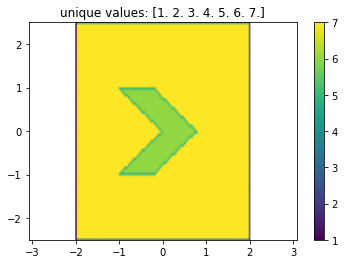

In [11]:
fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], tags, shading='Gouraud')
plt.colorbar(m, ax=ax)
ax.axis('equal')
ax.set_title(f"unique values: {np.unique(tags[~np.isnan(tags)])}");

In [12]:
X, Y = grid
r = np.arange(X.shape[0])
c = np.arange(X.shape[1])
C, R = np.meshgrid(c, r)

has_unknown = np.ones_like(tags, dtype=bool)
rcs = np.c_[R[has_unknown].flatten(), C[has_unknown].flatten()]

# Let's create some mappings to simplify the mapping.

rc2id = {}
id2rc = {}

for ind, (r, c) in enumerate(rcs):
    rc2id[(r, c)] = ind
    id2rc[ind] = (r, c)

# coef matrix
A = np.zeros((rcs.shape[0], rcs.shape[0]))
# rhs vector
B = np.zeros((rcs.shape[0],))
# v0
v0 = np.array([1., 0])
# grid params
dx = 1
dy = 1

for (r, c) in rc2id:
    this_point = rc2id[(r, c)]
    # left edge
    if tags[r, c] == 1:
        id_right = rc2id[(r, c+1)]
        id_left = rc2id[(r, c)]
        A[this_point, id_left] += 1/dx
        A[this_point, id_right] += -1/dx
        B[this_point] = -v0[0]
    # right edge
    elif tags[r, c] == 2:
        id_right = rc2id[(r, c)]
        id_left = rc2id[(r, c-1)]
        A[this_point, id_right] += 1/dx
        A[this_point, id_left] += -1/dx
        B[this_point] = v0[0]
    # top edge
    elif tags[r, c] == 4:
        id_top = rc2id[(r, c)]
        id_bottom = rc2id[(r-1, c)]
        A[this_point, id_top] += 1/dy
        A[this_point, id_bottom] += -1/dy
        B[this_point] = 0
    # bottom edge
    elif tags[r, c] == 3:
        id_top = rc2id[(r, c)]
        id_bottom = rc2id[(r+1, c)]
        A[this_point, id_top] += 1/dy
        A[this_point, id_bottom] += -1/dy
        B[this_point] = 0
    # interior boundary, interior volume and exterior volume
    else:
        id_bottom = rc2id[(r-1, c)]
        id_top = rc2id[(r+1, c)]
        id_right = rc2id[(r, c+1)]
        id_left = rc2id[(r, c-1)]
        id_center = rc2id[(r, c)]
        A[this_point, id_top] += -1/dy
        A[this_point, id_bottom] += -1/dy
        A[this_point, id_right] += -1/dx
        A[this_point, id_left] += -1/dx
        A[this_point, id_center] += (2/dx + 2/dy)

phi_sol = np.linalg.solve(A, B)

(-2.2, 2.2, -2.75, 2.75)

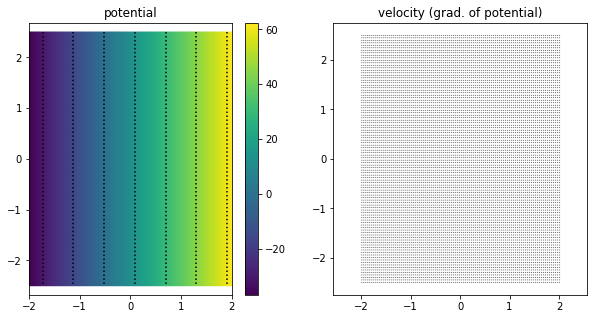

In [13]:
phi_mapped = np.zeros_like(tags) * np.nan
for _id, rc in id2rc.items():
    phi_mapped[rc[0], rc[1]] = phi_sol[_id]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
ax1.contour(grid[0], grid[1], phi_mapped, linestyles='dotted', colors="black")
plt.colorbar(m, ax=ax1)
ax1.axis('equal')
ax1.set_title("potential");

u, v = np.gradient(phi_mapped)
ax2.quiver(X, Y, v, u)
ax2.set_title("velocity (grad. of potential)");
ax2.axis('equal')

In [14]:
def assemble_and_solve(grid, x, y, nx, ny, tags):
    """Assembles and solves the potential flow from a curve (x, y, nx, ny) and on the given grid."""
    grid_coords = rasterize_points_to_grid_coords(x, y, grid)
    rasterized_vector_field = rasterize_vectors_to_grid(x, y, nx, ny, grid)

    assert grid_coords.shape[0] == rasterized_vector_field.shape[0]

    rc2normal = {}
    for rc, n in zip(grid_coords, rasterized_vector_field):
        rc2normal[(rc[0], rc[1])] = n

    X, Y = grid
    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)

    has_unknown = (tags != 6)
    rcs = np.c_[R[has_unknown].flatten(), C[has_unknown].flatten()]

    # Let's create some mappings to simplify the loops.

    rc2id = {}
    id2rc = {}

    for ind, (r, c) in enumerate(rcs):
        rc2id[(r, c)] = ind
        id2rc[ind] = (r, c)

    # coef matrix
    A = np.zeros((rcs.shape[0], rcs.shape[0]))
    # rhs vector
    B = np.zeros((rcs.shape[0],))
    # v0
    v0 = np.array([1., 0])
    # grid params
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]

    for (r, c) in rc2id:
        this_point = rc2id[(r, c)]
        # left edge
        if tags[r, c] == 1:
            id_right = rc2id[(r, c+1)]
            id_left = rc2id[(r, c)]
            A[this_point, id_left] += 1/dx
            A[this_point, id_right] += -1/dx
            B[this_point] = -v0[0]
        # right edge
        elif tags[r, c] == 2:
            id_right = rc2id[(r, c)]
            id_left = rc2id[(r, c-1)]
            A[this_point, id_right] += 1/dx
            A[this_point, id_left] += -1/dx
            B[this_point] = v0[0]
        # top edge
        elif tags[r, c] == 4:
            id_top = rc2id[(r, c)]
            id_bottom = rc2id[(r-1, c)]
            A[this_point, id_top] += 1/dy
            A[this_point, id_bottom] += -1/dy
            B[this_point] = 0
        # bottom edge
        elif tags[r, c] == 3:
            id_top = rc2id[(r, c)]
            id_bottom = rc2id[(r+1, c)]
            A[this_point, id_top] += 1/dy
            A[this_point, id_bottom] += -1/dy
            B[this_point] = 0
        # point on the interior boundary
        elif tags[r, c] == 5:
            nxx, nyy = rc2normal[(r, c)]
            id_center = rc2id[(r, c)]
            # vertical gradient
            if (r-1, c) in rc2id:
                id_bottom = rc2id[(r-1, c)]
                A[this_point, id_center] += 1/(dy) * nyy
                A[this_point, id_bottom] += -1/(dy) * nyy
            else:
                id_top = rc2id[(r+1, c)]
                A[this_point, id_center] += -1/(dy) * nyy
                A[this_point, id_top] += 1/(dy) * nyy

            # horizontal gradient
            if (r, c+1) in rc2id:
                id_right = rc2id[(r, c+1)]
                A[this_point, id_right] += 1/(dx) * nxx
                A[this_point, id_center] += -1/(dx) * nxx
            else:
                id_left = rc2id[(r, c-1)]
                A[this_point, id_center] += 1/(dx) * nxx
                A[this_point, id_left] += -1/(dx) * nxx

        # inside the volume
        elif tags[r, c] == 6:
            id_center = rc2id[(r, c)]
            A[this_point, id_center] = 1
            B[this_point] = 0
        else:
            id_bottom = rc2id[(r-1, c)]
            id_top = rc2id[(r+1, c)]
            id_right = rc2id[(r, c+1)]
            id_left = rc2id[(r, c-1)]
            id_center = rc2id[(r, c)]
            A[this_point, id_top] += -1/dy
            A[this_point, id_bottom] += -1/dy
            A[this_point, id_right] += -1/dx
            A[this_point, id_left] += -1/dx
            A[this_point, id_center] += (2/dx + 2/dy)

    phi_sol = np.linalg.solve(A, B)
    phi_mapped = np.zeros_like(tags) * np.nan
    for _id, rc in id2rc.items():
        phi_mapped[rc[0], rc[1]] = phi_sol[_id]
    return phi_mapped

phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)

KeyError: (50, 49)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
ax1.contour(grid[0], grid[1], phi_mapped)
plt.colorbar(m, ax=ax1)
ax1.axis('equal')
ax1.set_title("potential");

u, v = np.gradient(phi_mapped)
ax2.quiver(X, Y, v, u)
ax2.set_title("velocity (grad. of potential)");
ax2.axis('equal')

In [ ]:
fig, ax = plt.subplots()
ax.streamplot(X, Y, v, u)
ax.axis('equal')

In [ ]:
def make_plot(phi_mapped, grid, uv=None):
    """Plots a solution to the potential flow on the grid."""
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 4))
    m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
    ax1.contour(grid[0], grid[1], phi_mapped)
    plt.colorbar(m, ax=ax1)
    ax1.axis('equal')
    ax1.set_title("potential")
    
    if uv is not None:
        u, v = uv
    else:
        u, v = compute_gradient(grid, phi_mapped)

    ax2.quiver(grid[0], grid[1], u, v)
    ax2.set_title("velocity (grad. of potential)");
    ax2.axis('equal')
    ax3.streamplot(grid[0], grid[1], u, v)
    ax3.set_title('stream plot')
    ax3.axis('equal')
    plt.tight_layout()
def compute_gradient(grid, phi):
    """Numerically computes velocity as gradient of phi on grid."""
    X, Y = grid
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]
    v, u = np.gradient(phi, dx, dy)
    return u, v

In [ ]:
# define a parametric 2D cone
Lx=7
x = np.linspace(0, Lx, num=100) - Lx/2
t = np.linspace(0, np.max(x)/2, num=10, endpoint=False)

xhg, yhg = -np.max(x)/2+t,np.max(x)/2-t 
xbg,ybg = -t,-t
xhd, yhd = -t+Lx/5,t 
xbd,ybd = -np.max(x)/2+t+Lx/5,-np.max(x)/2+t
xh,yh = (2*(np.max(x)/2-t)/np.max(x))*Lx/5-np.max(x)/2,np.max(x)/2*np.ones(np.shape(t)[0])
xb,yb = 2*(t/np.max(x))*Lx/5-np.max(x)/2,-np.max(x)/2*np.ones(np.shape(t)[0])
x = np.concatenate((xbg,xb,xbd,xhd,xh,xhg))
y= np.concatenate((ybg,yb,ybd,yhd,yh,yhg))

nxbg,nybg = -1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),+1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxbd,nybd =1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),-1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxhg,nyhg =-1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),-1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxhd,nyhd =+1/(np.sqrt(2))*np.ones((np.shape(xhg)[0])),+1/(np.sqrt(2))*np.ones((np.shape(xhg)[0]))
nxh,nyh= 0*np.ones((np.shape(xhg)[0])),1*np.ones((np.shape(xhg)[0]))
nxb,nyb = 0*np.ones((np.shape(xhg)[0])),-1*np.ones((np.shape(xhg)[0]))


nx, ny = np.concatenate((nxbg,nxb,nxbd,nxhd,nxh,nxhg)), np.concatenate((nybg,nyb,nybd,nyhd,nyh,nyhg))

fig, ax = plt.subplots()
ax.plot(x, y, '-x')
ax.quiver(x, y, nx, ny)
ax.axis('equal');

In [ ]:
grid = make_grid(Lx=10, Ly=10, nx=22, ny=31)
tags = make_tags(grid, x, y)
phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)
phi_mapped -= np.nanmin(phi_mapped)

make_plot(phi_mapped, grid)